# Building A Wavenet

A wavenet is a language model that predicts audio sequences instead of character model. Our character model in this implementation will look very similar to a wavenet.

## The Network So Far

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

## Building The Vocabulary

In [3]:
words = open('../data/names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


## Building The Dataset

In [5]:
import random
random.seed(42)
random.shuffle(words)

In [6]:
block_size = 3

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


Here's how the inputs and targets look for our dataset.

In [7]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

... --> y
..y --> u
.yu --> h
yuh --> e
uhe --> n
hen --> g
eng --> .
... --> d
..d --> i
.di --> o
dio --> n
ion --> d
ond --> r
ndr --> e
dre --> .
... --> x
..x --> a
.xa --> v
xav --> i
avi --> e


## Our Layer Modules

In [8]:
class Linear:
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # kaiming init
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
        
    return self.out
    
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

In [9]:
class BatchNorm1d:
  def __init__(self, dim, eps=1e-5, momentum=0.1) -> None:
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # params trained with backprop
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers trained with running momentum update
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # forward pass
    if self.training:
        xmean = x.mean(0, keepdim=True) # batch mean
        xvar = x.var(0, keepdim=True, unbiased=True) # batch var
    else:
        xmean = self.running_mean
        xvar = self.running_var

    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # eps is added in denom to prevent div with 0 
    self.out = self.gamma * xhat + self.beta

    #update buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

    return self.out

  def parameters(self):
    return [self.gamma, self.beta]        

In [10]:
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

## Init Params

In [15]:
n_embed = 10
n_hidden = 200

C = torch.randn((vocab_size, n_embed))
layers = [
  Linear(n_embed * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size)
]

with torch.no_grad():
  layers[-1].weight *= 0.1 # make last layer less confident

parameters = [C] + [p for layer in layers for p in layer.parameters()] 
print(sum(p.nelement() for p in parameters))

for p in parameters:
  p.requires_grad = True

12097


## Training Loop

In [16]:
n_iters = 200_000
batch_size = 32
lossi = []

for i in range(n_iters):

  # mini batch const.
  ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb]
  x = emb.view(emb.shape[0], -1)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100_000 else 0.01 # lr decay
  for p in parameters:
    p.data += -lr * p.grad # lr * grad = update

  # track stats
  if i % 10_000 == 0:
    print(f'{i:7d}/{n_iters:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.2965
  10000/ 200000: 2.1614
  20000/ 200000: 2.1321
  30000/ 200000: 2.1973
  40000/ 200000: 2.2253
  50000/ 200000: 2.5225
  60000/ 200000: 2.3555
  70000/ 200000: 2.2308
  80000/ 200000: 1.7538
  90000/ 200000: 2.3690
 100000/ 200000: 2.0558
 110000/ 200000: 2.2141
 120000/ 200000: 2.0001
 130000/ 200000: 2.1754
 140000/ 200000: 2.3295
 150000/ 200000: 2.0062
 160000/ 200000: 2.2384
 170000/ 200000: 2.7533
 180000/ 200000: 2.5245
 190000/ 200000: 2.2070


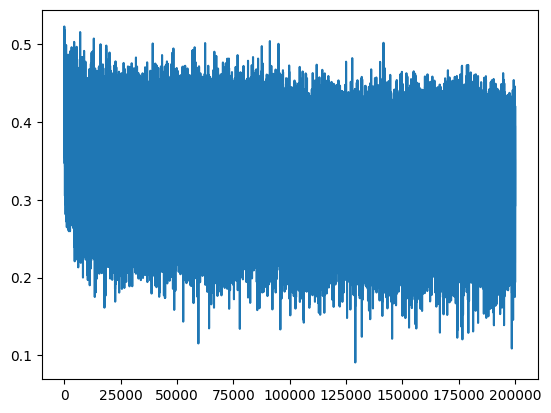

In [17]:
plt.plot(lossi);

Our loss graph is very thick because 32 batch elements are too few so the network can get very lucky or unlucky to get extreme values for loss per batch.

In [18]:
for layer in layers:
  layer.training = False

## Get The Split Loss

In [20]:
@torch.no_grad()
def split_loss(split):
  x, y = {
    'train': {Xtr, Ytr},
    'val': {Xdev, Ydev},
    'test': {Xte, Yte}
  }[split]

  emb = C[x]
  x = emb.view(emb.shape[0], -1)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

split_loss('train')  
split_loss('val')

train 2.0636727809906006
val 2.109046697616577


## Sample From The Network

In [23]:
n_samples = 20

for _ in range(n_samples):
  out = []
  context = [0] * block_size # init context with all dots ...
  while True:
    emb = C[torch.tensor([context])] # (1, block_size, d)
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
      x = layer(x)  
    logits = x
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print(''.join(itos[i] for i in out))    

veiros.
keyna.
kaixe.
lessla.
ann.
malynne.
rohensli.
more.
saa.
bryaquam.
zac.
tyn.
jizset.
truseph.
joha.
akhazary.
khadia.
kalon.
elo.
deslynn.
